In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sp
import os
import glob
import matplotlib.pyplot as plt
import imageio
import random
import umap

from matplotlib import colors as mcolors

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

In [3]:
colors = [mcolors.to_hex(c) for c in plt.cm.tab20.colors]

## 8 Agents, 1 Neighbors, 10 Artefacts, 50 Epochs

In [52]:
data_path = "../data/output/test_output_2020-07-07T11-28-36.npy"

x = np.load(data_path, allow_pickle=True)

artefact_means = np.array([a[6] for a in x]) # z_means
artefacts = np.array([a[4] for a in x]) # z
agent_ids = np.array([a[1] for a in x])

n_agents = 8
labels = [f"agent_0_{i}" for i in range(0, n_agents)]

print(artefacts.reshape(440, 10 * 12).shape)

(440, 120)


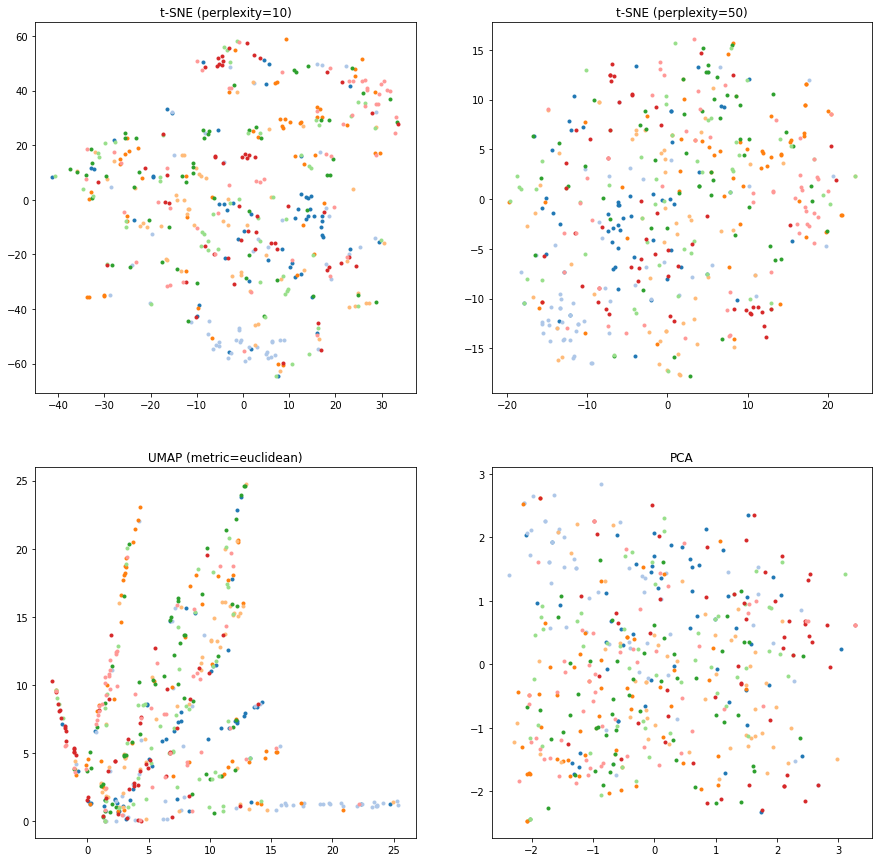

Number of artefacts: 440


In [67]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

perplexities = [10, 50]

for i, ax in enumerate(axs.flatten()):
    if i < 2:
        tsne = manifold.TSNE(n_components=2, random_state=1, perplexity=perplexities[i])
        embedded = tsne.fit_transform(artefact_means)
        ax.set_title(f"t-SNE (perplexity={perplexities[i]})")
    elif i == 2:
        metric = "euclidean"
        
        if metric == "manhattan" or metric == "euclidean":
            umap_artefacts = artefact_means
        
        if metric == "hamming":
            umap_artefacts = artefacts.reshape(440, 10 * 12)
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.0, metric=metric, output_metric="hyperboloid")
        embedded = reducer.fit_transform(umap_artefacts)
        ax.set_title(f"UMAP (metric={metric})")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(artefact_means)
        ax.set_title("PCA")

    for j, label in enumerate(labels):
        x, y = embedded[j::n_agents, 0], embedded[j::n_agents, 1]
        ax.scatter(x, y, c=colors[j % n_agents], label=label, marker=".")
    
plt.show()
print(f"Number of artefacts: {len(artefacts)}")

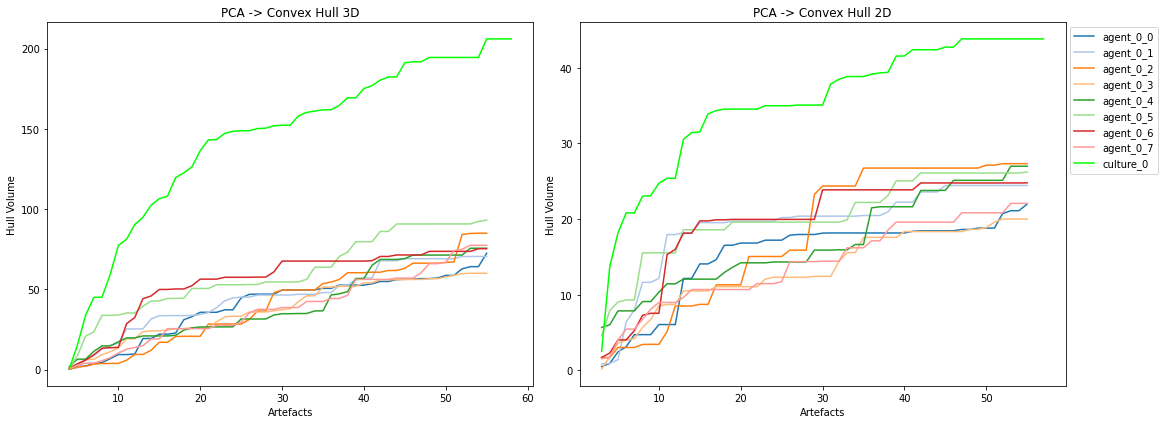

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# -- CONVEX HULLS 3D

pca_3d = decomposition.PCA(n_components=3)
pca_embedded_3d = pca_3d.fit_transform(artefacts)

agent_hulls_3d = []

for i in range(0, n_agents):
    volumes = []
    embeddded = pca_embedded_3d[i::n_agents]
    
    hull = sp.spatial.ConvexHull(embeddded[:4], incremental=True)
    volumes.append(hull.volume)

    for j in range(4, len(embeddded)):
        hull.add_points([embeddded[j]])
        volumes.append(hull.volume)
    hull.close()
    
    agent_hulls_3d.append(hull)

    ax[0].plot(range(4, len(volumes) + 4), volumes, c=colors[i % n_agents], label=labels[i])


culture_volumes_3d = []

culture_hull_3d = sp.spatial.ConvexHull(pca_embedded_3d[:4], incremental=True)
culture_volumes_3d.append(culture_hull_3d.volume)

for j in range(4, len(artefacts)):
    culture_hull_3d.add_points([pca_embedded_3d[j]])
    culture_volumes_3d.append(culture_hull_3d.volume)
culture_hull_3d.close()

x = range(4, round(len(culture_volumes_3d) / n_agents) + 4)
y = culture_volumes_3d[0::n_agents]

ax[0].plot(x, y, c='lime', label="culture_0")
ax[0].set_title('PCA -> Convex Hull 3D')
ax[0].set_ylabel('Hull Volume')
ax[0].set_xlabel('Artefacts')

# -- CONVEX HULLS 2D

pca_2d = decomposition.PCA(n_components=2)
pca_embedded_2d = pca_2d.fit_transform(artefacts)

agent_hulls_2d = []

for i in range(0, n_agents):
    volumes = []
    embeddded = pca_embedded_2d[i::n_agents]

    hull = sp.spatial.ConvexHull(embeddded[:3], incremental=True)
    volumes.append(hull.volume)

    for j in range(3, len(embeddded)):
        hull.add_points([embeddded[j]])
        volumes.append(hull.volume)
    hull.close()
    
    agent_hulls_2d.append(hull)

    ax[1].plot(range(3, len(volumes) + 3), volumes, c=colors[i % n_agents], label=labels[i])
 
 
culture_volumes_2d = []

culture_hull_2d = sp.spatial.ConvexHull(pca_embedded_2d[:3], incremental=True)
culture_volumes_2d.append(culture_hull_2d.volume)

for j in range(3, len(artefacts)):
    culture_hull_2d.add_points([pca_embedded_2d[j]])
    culture_volumes_2d.append(culture_hull_2d.volume)
culture_hull_2d.close()

x = range(3, round(len(culture_volumes_2d) / n_agents) + 3)
y = culture_volumes_2d[0::n_agents]

ax[1].plot(x, y, c='lime', label="culture_0")
ax[1].set_title('PCA -> Convex Hull 2D')
ax[1].set_ylabel('Hull Volume')
ax[1].set_xlabel('Artefacts')


plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

### 3D Projection of the Convex Hull, and their center points.

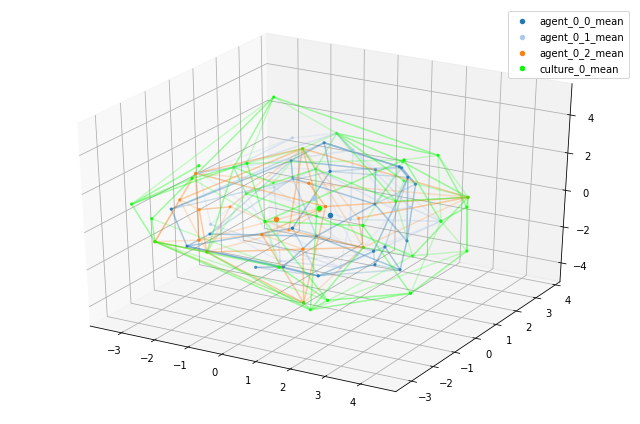

In [8]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

# -- AGENTS

# -- for now only project 3 agents, if all 8, it becomes very messy
for i, hull in enumerate(agent_hulls_3d[:3]):
    points = hull.points

    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], c=colors[i % n_agents], alpha=.2)
    
    vertices = np.array([[points[vertex, 0], points[vertex, 1], points[vertex, 2]] for vertex in hull.vertices])
    
    # every vertex is an artefact
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=colors[i % n_agents], marker=".")

    # the large dot in the centers is the mean
    mean = vertices.mean(axis=0)
    ax.scatter(mean[0], mean[1], mean[2], c=colors[i % n_agents], label=labels[i] + "_mean")

# -- CULTURE

points = culture_hull_3d.points

for simplex in culture_hull_3d.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], c="lime", alpha=.2)

vertices = np.array([[points[vertex, 0], points[vertex, 1], points[vertex, 2]] for vertex in culture_hull_3d.vertices])
    
# every vertex is an artefact
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c="lime", marker=".")

# the large dot in the centers is the mean
mean = vertices.mean(axis=0)
ax.scatter(mean[0], mean[1], mean[2], c="lime", label="culture_0_mean")


plt.tight_layout()
plt.legend()
plt.show()

### 2D Projection of the Convex Hull, and their center points.

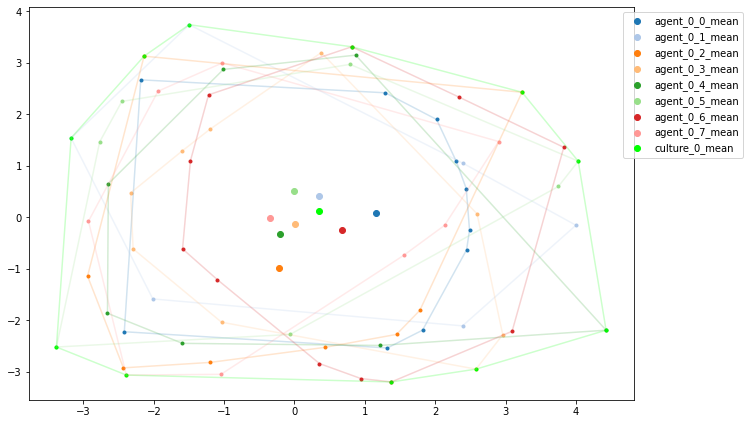

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# -- AGENTS

for i, hull in enumerate(agent_hulls_2d):
    points = hull.points

    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], c=colors[i % n_agents], alpha=.2)
    
    vertices = np.array([[points[vertex, 0], points[vertex, 1]] for vertex in hull.vertices])
    
    # every vertex is an artefact
    ax.scatter(vertices[:, 0], vertices[:, 1], c=colors[i % n_agents], marker=".")

    # the large dot in the centers is the mean
    mean = vertices.mean(axis=0)
    ax.scatter(mean[0], mean[1], c=colors[i % n_agents], label=labels[i] + "_mean")

# -- CULTURE

points = culture_hull_2d.points

for simplex in culture_hull_2d.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], c="lime", alpha=.2)

vertices = np.array([[points[vertex, 0], points[vertex, 1]] for vertex in culture_hull_2d.vertices])    

# every vertex is an artefact
ax.scatter(vertices[:, 0], vertices[:, 1], c="lime", marker=".")

# the large dot in the centers is the mean
mean = vertices.mean(axis=0)
ax.scatter(mean[0], mean[1], c="lime", label="culture_0_mean")


plt.tight_layout()
plt.legend(loc="upper right", bbox_to_anchor=(1.19, 1))
plt.show()

### The magnitudes of each artefact vector.

To keep it a readable, it only shows the first 2 agents.

The idea here is, as the agents settle down in one region, the magnitude should stabilize. However, that is not the case. From the large difference between one artefact and the next, they appear moving quite large distances.

Perhaps, to see if they really converge a specific area the origin (which is (0,0, ..., n), where n=32) should change with each artefact.

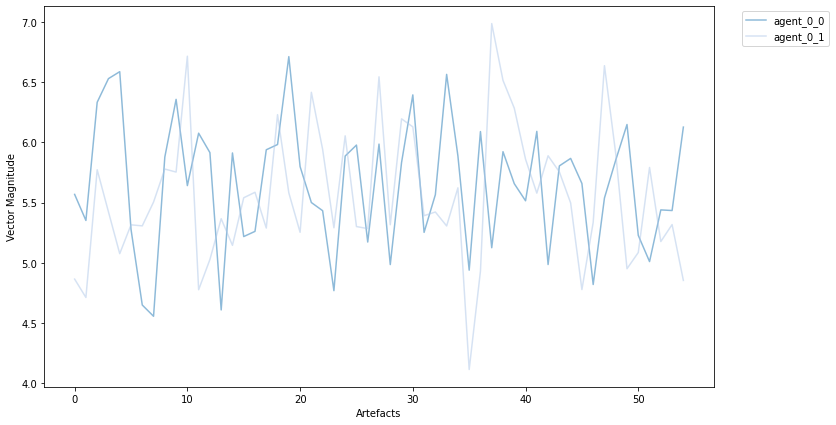

In [10]:
# -- the magnitude of each artefact vector.
# -- currently all derived from the origin
# -- could take the agent's first mean, or the mean of the convex hull as the origin.

fig_3, ax = plt.subplots(1, 1, figsize=(12, 7))

fit = []
norms = []
for i in range(0, 2): # n_agents 
    norm = np.array([np.linalg.norm(artefact) for artefact in artefacts[i::n_agents]])
    norms.append(norm)
    x = range(0, len(norm))
    ax.plot(x, norm, c=colors[i % n_agents], label=labels[i], alpha=0.5)
    ax.set_ylabel('Vector Magnitude')
    ax.set_xlabel('Artefacts')

plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1))
plt.show()

### Model Evaluation

It still seems fairly stable, no major deterioration.

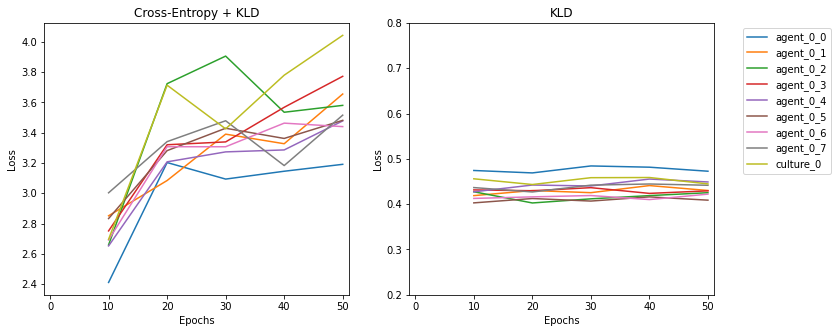

In [112]:
data_eval_path = "../data/output/test_output_2020-07-07T11-28-36_evaluations.npy"
evaluations = np.load(data_eval_path, allow_pickle=True)
evaluations = np.array([e for e in evaluation if len(e) > 0])

labels_eval = [f"agent_0_{i}" for i in range(n_agents)] + ["culture_0"] 
fig_4, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, label in enumerate(labels_eval):
    loss = np.array([epoch[i][0] for epoch in evaluations])
    kl_loss = np.array([epoch[i][1] for epoch in evaluations])

    axs[0].plot(range(10, (evaluations.shape[0] + 1) * 10, 10), loss, label=label)
    axs[1].plot(range(10, (evaluations.shape[0] + 1) * 10, 10), kl_loss, label=label)

axs[0].set_title('Cross-Entropy + KLD')
axs[1].set_title('KLD')

for ax in axs:
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.set_xlim(-1, len(evals) + 1)
    if axs[1] == ax:
        ax.set_ylim(0.2, 0.8)
    ax.set_xticks(np.arange(0, len(evals) + 1, 10))

plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

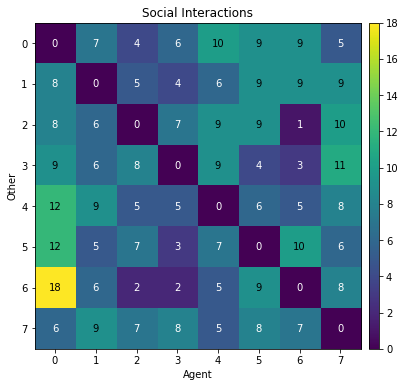

In [149]:
from state_of_the_artefact.helpers.plottools import plot_confusion_matrix

interactions = np.load("../data/output/test_output_2020-07-07T11-28-36_interactions.npy", allow_pickle=True)
cm = np.zeros((n_agents, n_agents), dtype='int')

for x in range(n_agents):
    neighbours = np.array([n[2] for n in interactions if n[1] == x])
    unique, counts = np.unique(neighbours.flatten(), return_counts=True)

    for i, y in enumerate(unique):
        cm[x, y] = counts[i]

n_interactions = interactions.shape[0] // n_agents
assert np.all(np.sum(cm, axis=1) == n_interactions), "The number of interactions of every agent is incorrect"

plot_confusion_matrix(cm, np.arange(0, n_agents + 1), 'Social Interactions', 'Agent', 'Other', cmap="viridis", colorbar=True, annotate=True)
plt.show()

In [4]:
reconstructions = np.load("../data/output/test_output_2020-07-07T11-28-36_reconstructions.npy", allow_pickle=True)

In [5]:
reconstructions.shape[0]

5

['xvZDZUbR', 'kvZHylRnR', 'xYZHQPRbh', 'evyHqhhbU', 'eYZDQxRnR']


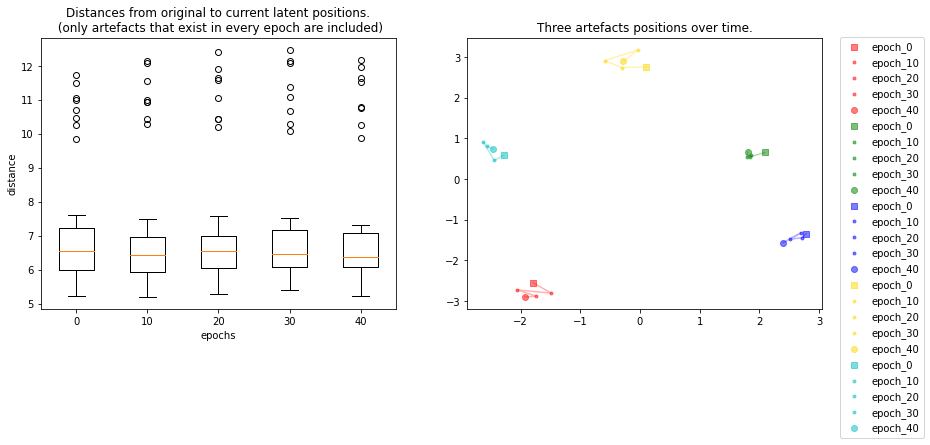

In [81]:
z_means_xvZDZUbR = []
z_means_kvZHylRnR = []
z_means_xYZHQPRbh = []
z_means_eYZDQxRnR = []
z_means_evyHqhhbU = []

labels = ["xvZDZUbR", "kvZHylRnR", "xYZHQPRbh"]
colors = ["r", "g", "b", "gold", "c"]
# colors = [mcolors.to_hex(c) for c in plt.cm.tab20.colors]
markers = ['s', '.', '.', '.', 'o' ]

z_means = []
norms = []
artefact_ids = [r[0] for r in reconstructions[0]]
print(artefact_ids[:5])

for e in range(len(reconstructions)):
    z_means_xvZDZUbR += [reconstruction[2] for reconstruction in reconstructions[e] if reconstruction[0] == 'xvZDZUbR']
    z_means_kvZHylRnR += [reconstruction[2] for reconstruction in reconstructions[e] if reconstruction[0] == 'kvZHylRnR']
    z_means_xYZHQPRbh += [reconstruction[2] for reconstruction in reconstructions[e] if reconstruction[0] == 'xYZHQPRbh']
    z_means_evyHqhhbU += [reconstruction[2] for reconstruction in reconstructions[e] if reconstruction[0] == 'evyHqhhbU']
    z_means_eYZDQxRnR += [reconstruction[2] for reconstruction in reconstructions[e] if reconstruction[0] == 'eYZDQxRnR']
    
    # z_means += [reconstruction[2] for reconstruction in reconstructions[e] if reconstruction[0] in artefact_ids]
    norms += [[np.linalg.norm(reconstruction[1] - reconstruction[2]) for reconstruction in reconstructions[e] if reconstruction[0] in artefact_ids]]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].boxplot(norms)
axs[0].set_title('Distances from original to current latent positions.\n (only artefacts that exist in every epoch are included)')
axs[0].set_xticklabels(["0", "10", "20", "30", "40"])
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('distance')

pca_2d = decomposition.PCA(n_components=2)
embedded = pca_2d.fit_transform(z_means_xvZDZUbR + z_means_kvZHylRnR + z_means_xYZHQPRbh + z_means_evyHqhhbU + z_means_eYZDQxRnR)

a = 0
for i, (x, y) in enumerate(embedded):
    if i >= (a + 1) * 5:
        a += 1
    axs[1].scatter(x, y, marker=markers[i % 5], c=colors[a], alpha=.5, label=f"epoch_{(i % 5) * 10}")

axs[1].plot(embedded[:5][:, 0], embedded[:5][:, 1], c="r", alpha=.3)
axs[1].plot(embedded[5:10][:, 0], embedded[5:10][:, 1], c="g", alpha=.3)
axs[1].plot(embedded[10:15][:, 0], embedded[10:15][:, 1], c="b", alpha=.3)
axs[1].plot(embedded[15:20][:, 0], embedded[15:20][:, 1], c="gold", alpha=.3)
axs[1].plot(embedded[20:25][:, 0], embedded[20:25][:, 1], c="c", alpha=.3)

axs[1].set_title('Three artefacts positions over time.')
axs[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.02))
plt.show()